In [438]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import timedelta
import seaborn as sns
import random
plt.style.use('ggplot')

In [439]:
def pd_dttm_import(want_cols):
    '''Parameters: takes in list of column names wanted that will be
    used in pandas .read_csv method
    
    Results: Outputs the indices of the columns names that are date
    values and uses resulting list of indices as parse_dates parameter
    in pandas .read_csv method'''
    dt_ind = []
    for i in want_cols:
        if 'dttm' in i.lower() or 'date' in i.lower():
            dt_ind.append(want_cols.index(i))
    return dt_ind

def to_time_delta_by_col(df, col, time2, time1):
    '''create new copy of data frame taking only not null values - to be used when wanting times matched up with
    single other column
    '''
    #create new copy of data frame taking only not null values
    df_ind = df[df[time1].notna() & df[time2].notna()]
    frame = pd.DataFrame(df_ind[col])
    frame['time_delta'] = (df_ind[time2] - df_ind[time1]).apply(lambda x: timedelta.total_seconds(x))
    return frame

def to_time_delta(df, time2, time1):
    '''Return series of seconds difference between two datetime columns
    '''
    #create new copy of data frame taking only not null values
    return (df[time2] - df[time1]).apply(lambda x: timedelta.total_seconds(x) if not isinstance(x, pd._libs.tslibs.nattype.NaTType) else None)

In [440]:
#need to ensure this is correct so that it can appropriately parse the date columns
all_columns = ['Call Number', 'Unit ID', 'Incident Number', 'Call Type', 'Call Date',
       'Watch Date', 'Received DtTm', 'Entry DtTm', 'Dispatch DtTm',
       'Response DtTm', 'On Scene DtTm', 'Transport DtTm', 'Hospital DtTm',
       'Call Final Disposition', 'Available DtTm', 'Address', 'City',
       'Zipcode of Incident', 'Battalion', 'Station Area', 'Box',
       'Original Priority', 'Priority', 'Final Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch', 'Fire Prevention District',
       'Supervisor District', 'Neighborhooods - Analysis Boundaries',
       'Location', 'RowID', 'shape', 'Supervisor Districts',
       'Fire Prevention Districts', 'Current Police Districts',
       'Neighborhoods - Analysis Boundaries', 'Zip Codes',
       'Neighborhoods (old)', 'Police Districts',
       'Civic Center Harm Reduction Project Boundary', 'HSOC Zones',
       'Central Market/Tenderloin Boundary Polygon - Updated', 'Neighborhoods',
       'SF Find Neighborhoods', 'Current Police Districts 2',
       'Current Supervisor Districts']

In [441]:
df = pd.read_csv('Fire_Department_Calls_for_Service.csv',
                 skiprows = (lambda x: x != 0 and random.random() > 0.2),
                 parse_dates = pd_dttm_import(all_columns))

orig_size = len(df)
print(f'Number of entries: {orig_size}')

/home/christopher/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,20,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of entries: 1090887


### Take a look at the dataframe info

In [442]:
#there are many instances of the call being dispatched to multiple people, no point in looking into that
tot = 0
for i in ['Received DtTm', 'Dispatch DtTm', 'Response DtTm', 'On Scene DtTm']:
    tot += len(df[df[i].isnull()])
    print(f'Number of entries where {i} is NaN: {tot}')
print(f'Percentage of values where time is NaN: {tot/len(df)*100}')


Number of entries where Received DtTm is NaN: 0
Number of entries where Dispatch DtTm is NaN: 0
Number of entries where Response DtTm is NaN: 83660
Number of entries where On Scene DtTm is NaN: 328149
Percentage of values where time is NaN: 30.080934138916316


In [443]:
#drop rows where any of the of-interest time data is NaN
#comfortable dropping this because if any is missing it suggests that the call led to no interaction with EMS
df.dropna(axis = 0, how = 'any', subset = ['Received DtTm', 'Dispatch DtTm', 'Response DtTm', 'On Scene DtTm'], inplace=True)

In [444]:
df['call_to_disp'] = to_time_delta(df,'Dispatch DtTm', 'Received DtTm')
df['disp_to_resp'] = to_time_delta(df, 'Response DtTm','Dispatch DtTm')
df['resp_to_scene'] = to_time_delta(df, 'On Scene DtTm','Response DtTm')
#at the moment not interested in time to transport to hospital
#df['time_to_hosp'] = to_time_delta(df, 'Hospital DtTm', 'Transport DtTm')


In [445]:
times = ['call_to_disp','disp_to_resp','resp_to_scene']

In [446]:
#view amount of data that has illogical timestamps (<=1)
for col in times:
    num = len(df[df[col] <= 0])
    print(f'{col} values < or = 0: {num} | {(num/len(df))*100:.2f}%')

call_to_disp values < or = 0: 5515 | 0.68%
disp_to_resp values < or = 0: 20718 | 2.56%
resp_to_scene values < or = 0: 13975 | 1.73%


In [447]:
#find all rows where any of the time values are irregular, not interested in calls where no one ends up on scene
tot = df[(df['call_to_disp'] <= 0) | (df['disp_to_resp'] <= 0) | (df['resp_to_scene'] <= 0)]
print(f'Total : {len(tot)}     | Percentage of Data: {len(tot)/len(df)*100:.2f}%')

Total : 29507     | Percentage of Data: 3.65%


In [448]:
#remove the rows with illogical time steps
for col in times:
    df = df[df[col] > 0]

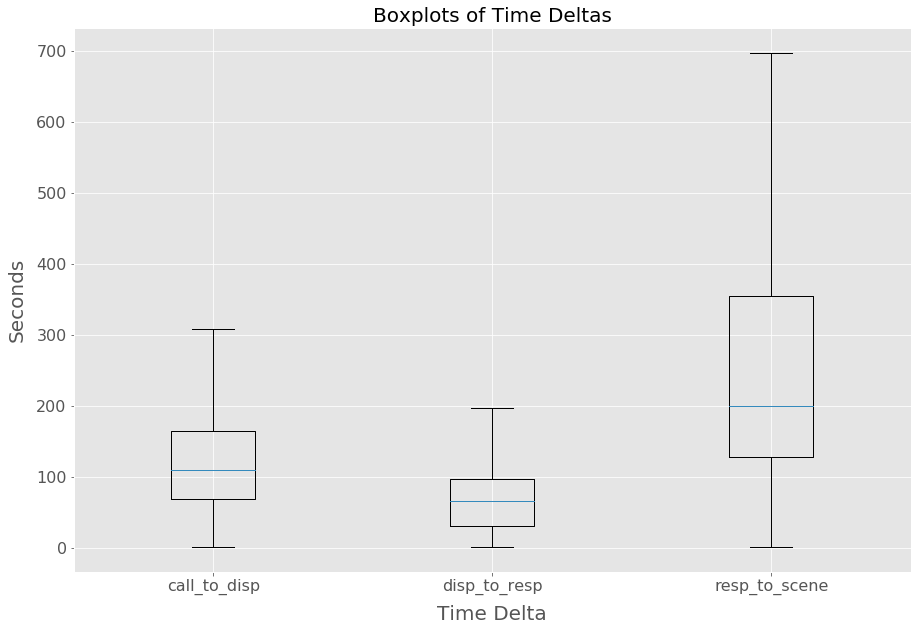

In [456]:
plt.figure(figsize=(15,10))
plt.boxplot((df['call_to_disp'],df['disp_to_resp'],df['resp_to_scene']), labels = times, sym='')
plt.ylabel('Seconds', fontdict = {'fontsize' : 20}, labelpad = 10)
plt.xlabel('Time Delta', fontdict = {'fontsize' : 20}, labelpad = 10)
plt.title('Boxplots of Time Deltas', fontdict = {'fontsize' : 20})
plt.tick_params(labelsize = 16)


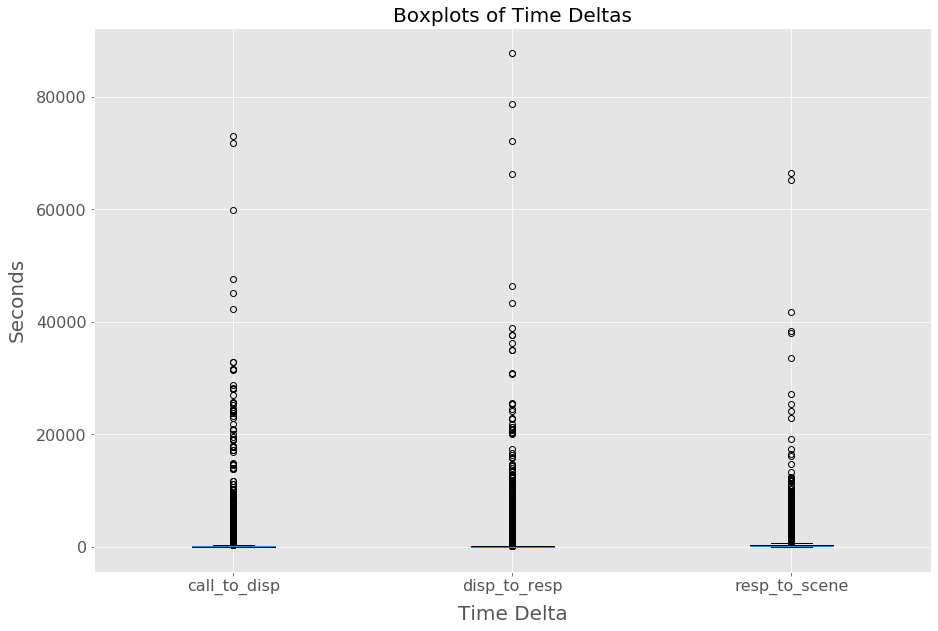

In [457]:
plt.figure(figsize=(15,10))
plt.boxplot((df['call_to_disp'],df['disp_to_resp'],df['resp_to_scene']), labels = times)
plt.ylabel('Seconds', fontdict = {'fontsize' : 20}, labelpad = 10)
plt.xlabel('Time Delta', fontdict = {'fontsize' : 20}, labelpad = 10)
plt.title('Boxplots of Time Deltas', fontdict = {'fontsize' : 20})
plt.tick_params(labelsize = 16)

In [458]:
#anything over 1 hour I am going to take as a mistake and cap at 1 hour

In [459]:
for i in times:
    df[i] = df[i].apply(lambda x: x if x < 3600 else 3600)

In [460]:
#check number of values over 2.5 times standard deviation
#given how many time stamps errors are made, that makes me more confident in removing the outliers, rather than trusting them
#also, what good is predicting that an ambulence will take 3 hours? There's no way the data available indicates the cause of such and annomaly

In [461]:
def data_above_mean(df, cols, std_mult):
    '''Takes in dataframe, list of column names in dataframe, and number of standard deviations above mean
    of interest and outputs the amount of the data in each column that is above that limit'''
    for col in cols:
        stan = df[col].std()
        mn = df[col].mean()
        print(f'{col:13} percent of values over {std_mult}x std above mean ({std_mult*stan+mn:.0f}): % {(len(df[df[col] > std_mult*stan+mn])/len(df))*100:.3f}')

In [462]:
data_above_mean(df, times, 2.5)

call_to_disp  percent of values over 2.5x std above mean (541): % 1.469
disp_to_resp  percent of values over 2.5x std above mean (410): % 1.224
resp_to_scene percent of values over 2.5x std above mean (1028): % 3.076


In [463]:
#however, the 2.5x outlier includes far to much data for resp_to_scene and time_to_hosp

In [464]:
data_above_mean(df,times,3)

call_to_disp  percent of values over 3x std above mean (622): % 1.159
disp_to_resp  percent of values over 3x std above mean (475): % 1.028
resp_to_scene percent of values over 3x std above mean (1174): % 2.049


#### Alternative: Remove all outliers - but going to leave in for now

In [465]:
#can drop earlier DtTm columns except Received DtTm - going to do some feature engineering on that
df.drop(labels=['Entry DtTm','Dispatch DtTm','Response DtTm','On Scene DtTm','Transport DtTm',
               'Hospital DtTm','Available DtTm'], axis=1, inplace = True)

In [467]:
#since keeping received dttm, can drop call date
df.drop(labels = 'Call Date', axis=1, inplace = True)

# Worth Exploring - but not to include in model

In [299]:
df['Battalion'].value_counts()

B02    62669
B03    60651
B01    39198
B04    36639
B08    30920
B10    30753
B09    28716
B05    27829
B06    27140
B07    19150
B99     1462
Name: Battalion, dtype: int64

In [300]:
df['Station Area'].value_counts()

1.0     40206
3.0     30906
36.0    18920
7.0     16473
6.0     11613
        ...  
47         50
51         36
53         12
47          1
94          1
Name: Station Area, Length: 97, dtype: int64

In [303]:
df['Original Priority'].value_counts()

3    270614
2     56744
E     12388
1     11600
A      6477
B      3538
C      2070
I       307
Name: Original Priority, dtype: int64

In [304]:
df['Priority'].value_counts()

3    271207
2     65781
E     15583
1     12173
A       259
B       103
C        14
I         7
Name: Priority, dtype: int64

In [305]:
df['Final Priority'].value_counts()

3    286811
2     78316
Name: Final Priority, dtype: int64

In [311]:
df['Fire Prevention District'].value_counts()

2       69852
3       53385
1       39681
4       33767
10      29950
9       29784
6       28538
8       28292
5       26957
7       22004
None     2255
7.0        96
8.0        86
9.0        82
6.0        79
10.0       78
3.0        61
2.0        58
4.0        50
5.0        41
1.0        31
Name: Fire Prevention District, dtype: int64

In [314]:
df['Location'].value_counts()

(37.777624238929, -122.39998111124)         1442
(37.786117211838, -122.419854245692)        1281
(37.783386237938, -122.409853729941)         922
(37.78114586126, -122.409026046516)          915
(37.784091036176, -122.411784369455)         839
                                            ... 
37 775803                                      1
(37.783652064151, -122.445349021992)           1
(37.75516614552716, -122.43660270280508)       1
(37.76288986683952, -122.42850874957381)       1
(37.720598354428, -122.450546377216)           1
Name: Location, Length: 43227, dtype: int64

In [315]:
df['RowID']

0         202732150-QRV2
1          203441003-E14
2          202592942-E28
5          202571889-T07
6           203383383-83
               ...      
544107     210040917-E23
544108     210040729-B06
544109      210041941-58
544112      210040973-62
544113     210042994-E16
Name: RowID, Length: 365127, dtype: object

In [ ]:
#various districts

In [324]:
df['Neighborhoods - Analysis Boundaries'].value_counts()

36.0    45996
20.0    34383
34.0    33756
8.0     23211
1.0     19343
35.0    14746
39.0    13921
21.0    11794
29.0     9592
9.0      9138
5.0      8893
41.0     8308
30.0     7928
6.0      7452
23.0     7426
7.0      7371
13.0     6925
2.0      6879
14.0     6007
32.0     5690
3.0      5671
16.0     5506
24.0     5374
28.0     5303
11.0     5096
40.0     4775
26.0     4657
18.0     4508
4.0      4230
22.0     4044
25.0     3486
15.0     3467
31.0     3293
38.0     2288
12.0     1994
10.0     1887
37.0     1765
27.0      935
33.0      541
19.0      418
17.0      299
Name: Neighborhoods - Analysis Boundaries, dtype: int64

In [331]:
df['SF Find Neighborhoods'].value_counts()

32.0     39937
20.0     32765
53.0     22966
39.0     10018
50.0      9644
         ...  
116.0      255
69.0       162
70.0       121
7.0        101
73.0        81
Name: SF Find Neighborhoods, Length: 117, dtype: int64

In [333]:
df['Neighborhoods'].value_counts()

32.0     39937
20.0     32765
53.0     22966
39.0     10018
50.0      9644
         ...  
116.0      255
69.0       162
70.0       121
7.0        101
73.0        81
Name: Neighborhoods, Length: 117, dtype: int64

In [329]:
df['Central Market/Tenderloin Boundary Polygon - Updated'].value_counts()

1    60286
Name: Central Market/Tenderloin Boundary Polygon - Updated, dtype: int64

In [288]:
df.columns

Index(['Call Number', 'Unit ID', 'Incident Number', 'Call Type', 'Call Date',
       'Watch Date', 'Received DtTm', 'Entry DtTm', 'Dispatch DtTm',
       'Response DtTm', 'On Scene DtTm', 'Transport DtTm', 'Hospital DtTm',
       'Call Final Disposition', 'Available DtTm', 'Address', 'City',
       'Zipcode of Incident', 'Battalion', 'Station Area', 'Box',
       'Original Priority', 'Priority', 'Final Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch', 'Fire Prevention District',
       'Supervisor District', 'Neighborhooods - Analysis Boundaries',
       'Location', 'RowID', 'shape', 'Supervisor Districts',
       'Fire Prevention Districts', 'Current Police Districts',
       'Neighborhoods - Analysis Boundaries', 'Zip Codes',
       'Neighborhoods (old)', 'Police Districts',
       'Civic Center Harm Reduction Project Boundary', 'HSOC Zones',
       'Central Market/Tenderloin Boundary Polygon - Updated', 'Neighb

In [ ]:
#can drop this also

In [479]:
df['Address'].value_counts()
#can use street names

0 Block of 6TH ST               4687
800 Block of MARKET ST          3924
500 Block of 5TH ST             3338
300 Block of EDDY ST            3252
200 Block of EDDY ST            3150
                                ... 
SILLIMAN ST/COLBY ST               1
2100 Block of GEARY BL             1
PRENTISS ST/JARBOE AV              1
1500 Block of GOLDEN GATE AV       1
VASQUEZ AV/WOODSIDE AV             1
Name: Address, Length: 25125, dtype: int64

In [477]:
df['shape'].value_counts()
#looking into these coordinates, first two line up with SF homeless shelters

POINT (-122.39998111124 37.777624238929)         3028
POINT (-122.419854245692 37.786117211838)        2735
POINT (-122.409026046516 37.78114586126)         1993
POINT (-122.409853729941 37.783386237938)        1918
POINT (-122.411784369455 37.784091036176)        1820
                                                 ... 
POINT (-122.453292601673 37.795890573989)           1
POINT (-122.48972214842527 37.75926486231849)       1
POINT (-122.46588185145806 37.77433796676059)       1
POINT (-122.442391802958 37.757161853568)           1
POINT (-122.49790553915231 37.75235792745348)       1
Name: shape, Length: 50623, dtype: int64

## Checking to see if features are useable
- For categorical, make sure there are not too many values to dummify, and search for outliers

In [466]:
df.columns

Index(['Call Number', 'Unit ID', 'Incident Number', 'Call Type', 'Call Date',
       'Watch Date', 'Received DtTm', 'Call Final Disposition', 'Address',
       'City', 'Zipcode of Incident', 'Battalion', 'Station Area', 'Box',
       'Original Priority', 'Priority', 'Final Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch', 'Fire Prevention District',
       'Supervisor District', 'Neighborhooods - Analysis Boundaries',
       'Location', 'RowID', 'shape', 'Supervisor Districts',
       'Fire Prevention Districts', 'Current Police Districts',
       'Neighborhoods - Analysis Boundaries', 'Zip Codes',
       'Neighborhoods (old)', 'Police Districts',
       'Civic Center Harm Reduction Project Boundary', 'HSOC Zones',
       'Central Market/Tenderloin Boundary Polygon - Updated', 'Neighborhoods',
       'SF Find Neighborhoods', 'Current Police Districts 2',
       'Current Supervisor Districts', 'call_to_disp', 'disp

In [481]:
'''Can remove columns that have information I am not interested in,
Unit ID : Too many to use in a model, but can look into it
Incident Number: Not much info in there except tracking if Units were on same call - could feature engineer into ambulances already responded
Watch Date: Redundant, don't need

remove location data besides neighborhood - Can try and do more with potential traffic hazzards later, but will generally be captured by neighborhood
Address: Can use feature to note places where calls are happening really frequently,
City,
Zipcode of Incident: redundant with neighborhood,
Battalion,
Station Area,
Box,
Fire Prevention District,
Supervisor District (not sure what this is so won't use it),
Location (can try to domore with this column based on congestion in that area)

Remove also:
RowID: don't need it,
shape, Supervisor Districts, Fire Prevention Districts,
Current Police Districts, Neighborhoods (both of them), Zip Codes, Police Districts, Neighborhoods, SF Find Neighborhoods
Current Police Districts 2, Current Supervisor Districts'''

"Can remove columns that have information I am not interested in,\nUnit ID : Too many to use in a model, but can look into it\nIncident Number: Not much info in there except tracking if Units were on same call - could feature engineer into ambulances already responded\nWatch Date: Redundant, don't need\n\nremove location data besides neighborhood - Can try and do more with potential traffic hazzards later, but will generally be captured by neighborhood\nAddress: Can use feature to note places where calls are happening really frequently,\nCity,\nZipcode of Incident: redundant with neighborhood,\nBattalion,\nStation Area,\nBox,\nFire Prevention District,\nSupervisor District (not sure what this is so won't use it),\nLocation (can try to domore with this column based on congestion in that area)\n\nRemove also:\nRowID: don't need it,\nshape, Supervisor Districts, Fire Prevention Districts,\nCurrent Police Districts, Neighborhoods (both of them), Zip Codes, Police Districts, Neighborhoods, 

#### Alternative: Keep Incident Number in there to see any correlation

In [70]:
df.columns

Index(['Call Number', 'Unit ID', 'Incident Number', 'Call Type', 'Call Date',
       'Watch Date', 'Call Final Disposition', 'Address', 'City',
       'Zipcode of Incident', 'Battalion', 'Station Area', 'Box',
       'Original Priority', 'Priority', 'Final Priority', 'ALS Unit',
       'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch', 'Fire Prevention District',
       'Supervisor District', 'Neighborhooods - Analysis Boundaries',
       'Location', 'RowID', 'shape', 'Supervisor Districts',
       'Fire Prevention Districts', 'Current Police Districts',
       'Neighborhoods - Analysis Boundaries', 'Zip Codes',
       'Neighborhoods (old)', 'Police Districts',
       'Civic Center Harm Reduction Project Boundary', 'HSOC Zones',
       'Central Market/Tenderloin Boundary Polygon - Updated', 'Neighborhoods',
       'SF Find Neighborhoods', 'Current Police Districts 2',
       'Current Supervisor Districts', 'call_to_disp', 'disp_to_resp',
      

In [482]:
remove_lst = ['Unit ID','Incident Number','Watch Date','Call Final Disposition','Address','City',
              'Zipcode of Incident', 'Battalion','Station Area','Box','Fire Prevention District',
              'Supervisor District','Location','RowID','shape','Supervisor Districts','Fire Prevention Districts',
              'Current Police Districts','Neighborhoods - Analysis Boundaries','Zip Codes','Neighborhoods (old)',
              'Police Districts','Neighborhoods','SF Find Neighborhoods','Current Police Districts 2',
              'Current Supervisor Districts']

## Pipeline: find indexes at points not in this list to include ^

In [483]:
df.drop(labels=remove_lst, axis=1, inplace=True)

## Investigate remaining features

In [484]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778784 entries, 0 to 1090885
Data columns (total 18 columns):
Call Number                                             778784 non-null int64
Call Type                                               778784 non-null object
Received DtTm                                           778784 non-null datetime64[ns]
Original Priority                                       775689 non-null object
Priority                                                778784 non-null object
Final Priority                                          778784 non-null int64
ALS Unit                                                778784 non-null bool
Call Type Group                                         388841 non-null object
Number of Alarms                                        778784 non-null int64
Unit Type                                               778784 non-null object
Unit sequence in call dispatch                          778778 non-null float64
Neighborhooods 

#### Remove things with a lot of null values

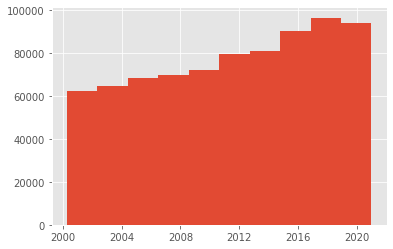

In [486]:
#going to be checking by dates, check overall trend of calls
df['Received DtTm'].hist()

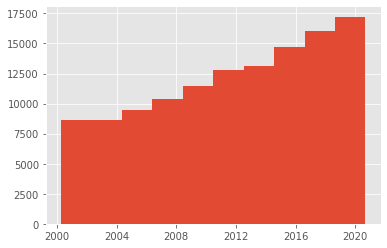

In [487]:
#I believe the last 3 columns are new ones, and might leave them in if I decide to run regression on only recent events
df['Received DtTm'][~df['Civic Center Harm Reduction Project Boundary'].isnull()].hist()

In [175]:
#seems like there has been a relative increase in including column recently, but is still too sparse to bother using
#Verdict: Can remove Civic Center Harm Reduction Project Boundary

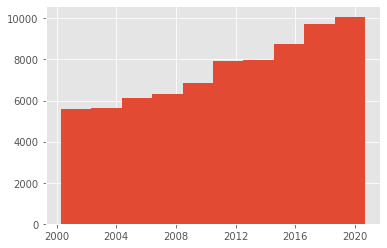

In [176]:
#I believe the last 3 columns are new ones, and might leave them in if I decide to run regression on only recent events
df['Call Date'][~df['HSOC Zones'].isnull()].hist()

In [177]:
#seems like there has been a relative increase in including column recently, but is still too sparse to bother using
#Verdict: Can remove HSOC Zones

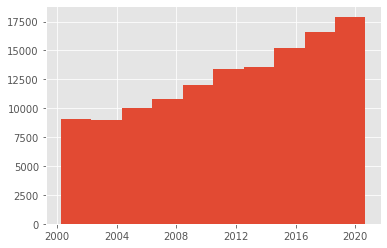

In [491]:
#I believe the last 3 columns are new ones, and might leave them in if I decide to run regression on only recent events
df['Received DtTm'][~df['Central Market/Tenderloin Boundary Polygon - Updated'].isnull()].hist()

In [492]:
#seems like there has been a relative increase in including column recently, but is still too sparse to bother using
#Verdict: Can remove Central Market/Tenderloin Boundary Polygon - Updated

In [493]:
to_rmv = ['Civic Center Harm Reduction Project Boundary',
          'HSOC Zones',
          'Central Market/Tenderloin Boundary Polygon - Updated']

In [494]:
df.drop(labels=to_rmv, axis=1, inplace=True)

### Investigate 'Unit sequence in call dispatch' column

In [495]:
#I believe this is how many other current calls were being actively dispatched at the same time

In [496]:
df['Unit sequence in call dispatch'].unique()[:None]

array([ 2.,  1.,  3.,  4.,  5.,  6., 11., 18., 17., 23., 29., 24.,  7.,
       10.,  8.,  9., 12., 77., 14., 60., 65., 30., 67., 53., 85., 13.,
       32., 28., 26., 27., 19., 56., 16., 15., 39., 41., 31., 70., 48.,
       33., 87., 22., 21., 20., 25., 34., 37., 36., 46., 38., 40., 51.,
       42., 35., 43., 44., 57., 52., 45., 59., 54., 61., 49., 47., 58.,
       nan, 55., 64., 74., 66., 62.])

In [497]:
def plot_bar_graph(df, col_name, low_limit = None, high_limit = None, font_size = 10, tick_size = 10, rot = 'vertical'):
    '''Takes in dataframe, column, and the number of unique values you would like to see in descending order
    based on value counts and outputs a bar graph'''

    
    plt.figure(figsize =(20,15))  
    labels_ = df[col_name].value_counts().index[low_limit:high_limit]
    if type(df[col_name][0]) == str:
        plt.xticks(ticks=range(len(labels_)), labels = labels_, rotation=rot)
    else:
        plt.xticks(labels_)
    plt.tick_params(labelsize=tick_size)
    plt.bar(x = df[col_name].value_counts().index[low_limit:high_limit], height = df[col_name].value_counts().values[low_limit:high_limit])
    plt.title(f'Counts of {col_name}', fontdict = {'fontsize' : font_size})
    plt.xlabel(f'{col_name}', fontdict = {'fontsize' : font_size})
    plt.ylabel('Counts', fontdict = {'fontsize' : font_size})
       

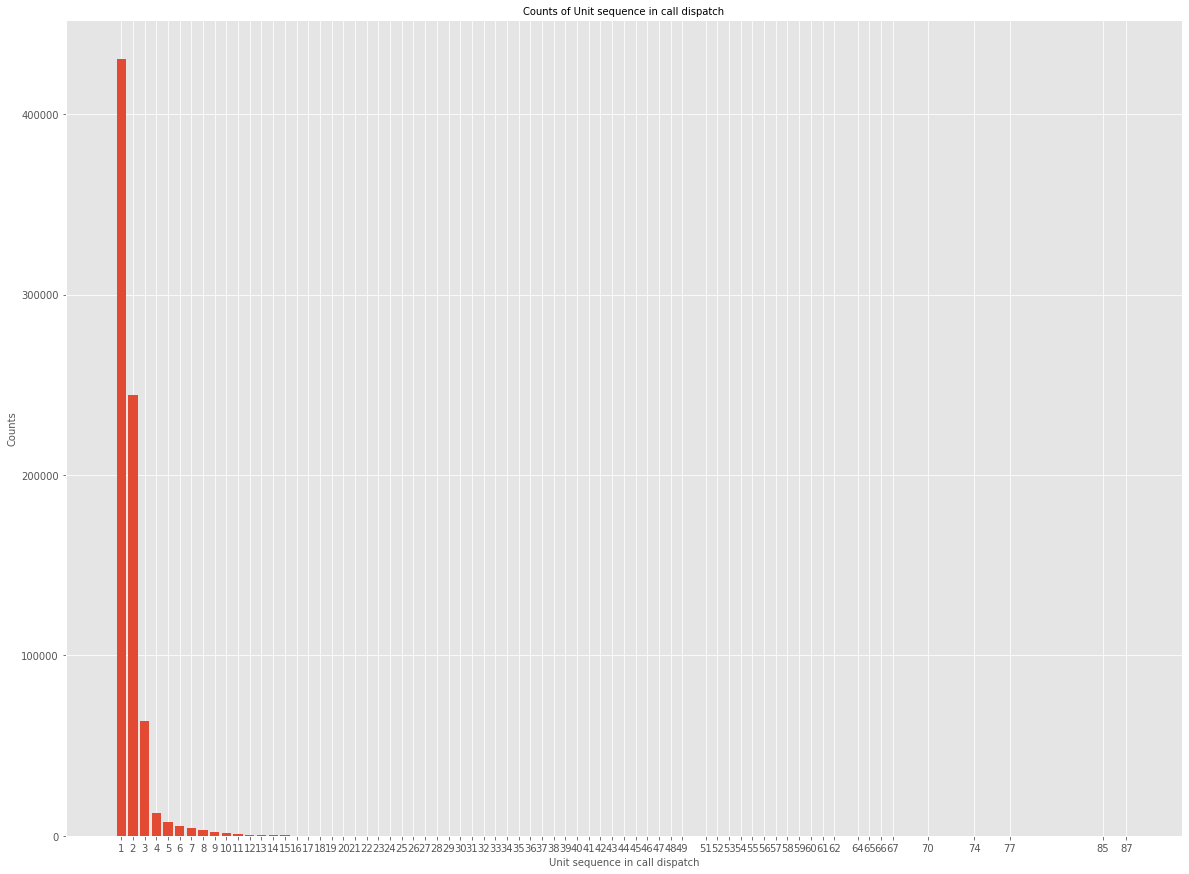

In [498]:
plot_bar_graph(df, 'Unit sequence in call dispatch')

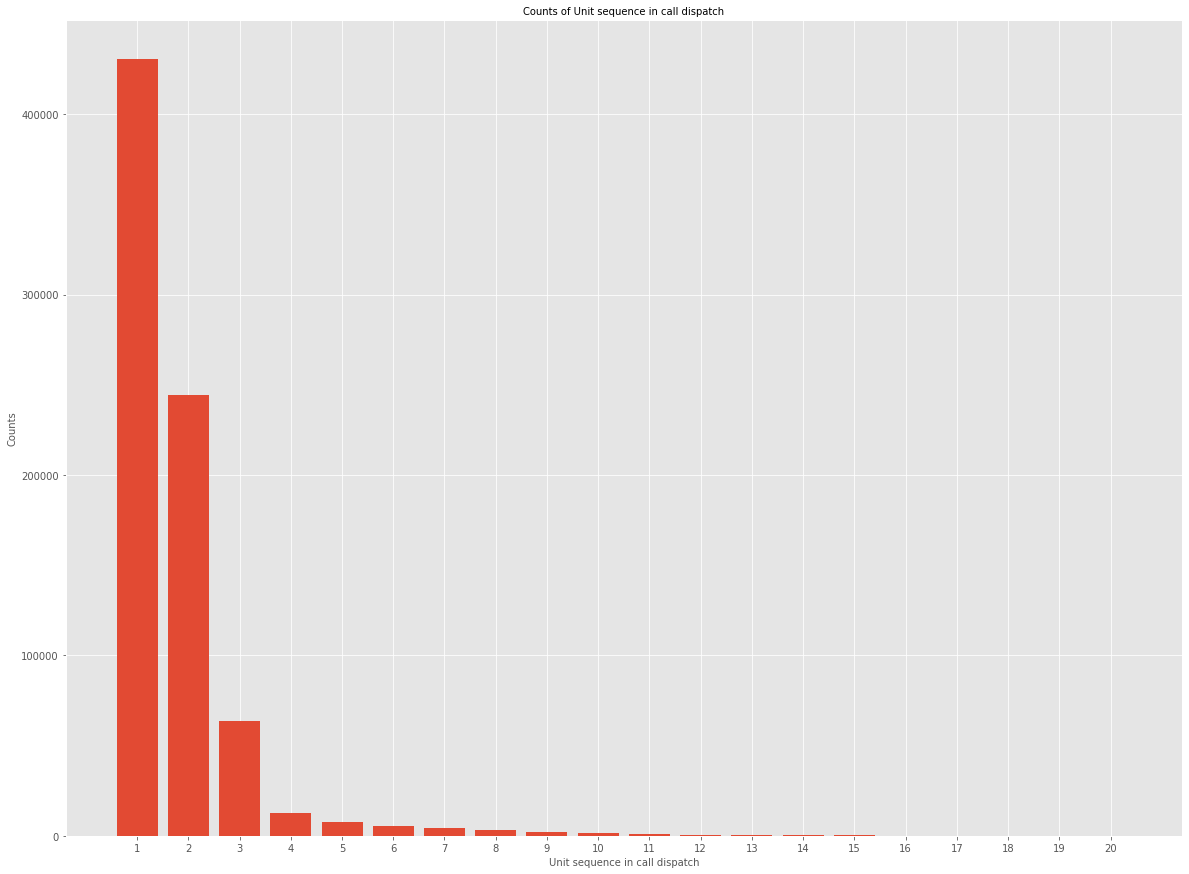

In [499]:
#Seems to end significant amounts around 20, will investigate dates of days with unusually high values
plot_bar_graph(df, 'Unit sequence in call dispatch', high_limit=20)

In [506]:
df['Received DtTm'].apply(lambda x: x.date())

0          2020-12-09
1          2020-09-18
2          2020-12-09
3          2020-12-09
4          2020-09-18
              ...    
1090880    2021-01-04
1090881    2021-01-04
1090882    2021-01-04
1090884    2021-01-04
1090885    2021-01-04
Name: Received DtTm, Length: 778784, dtype: object

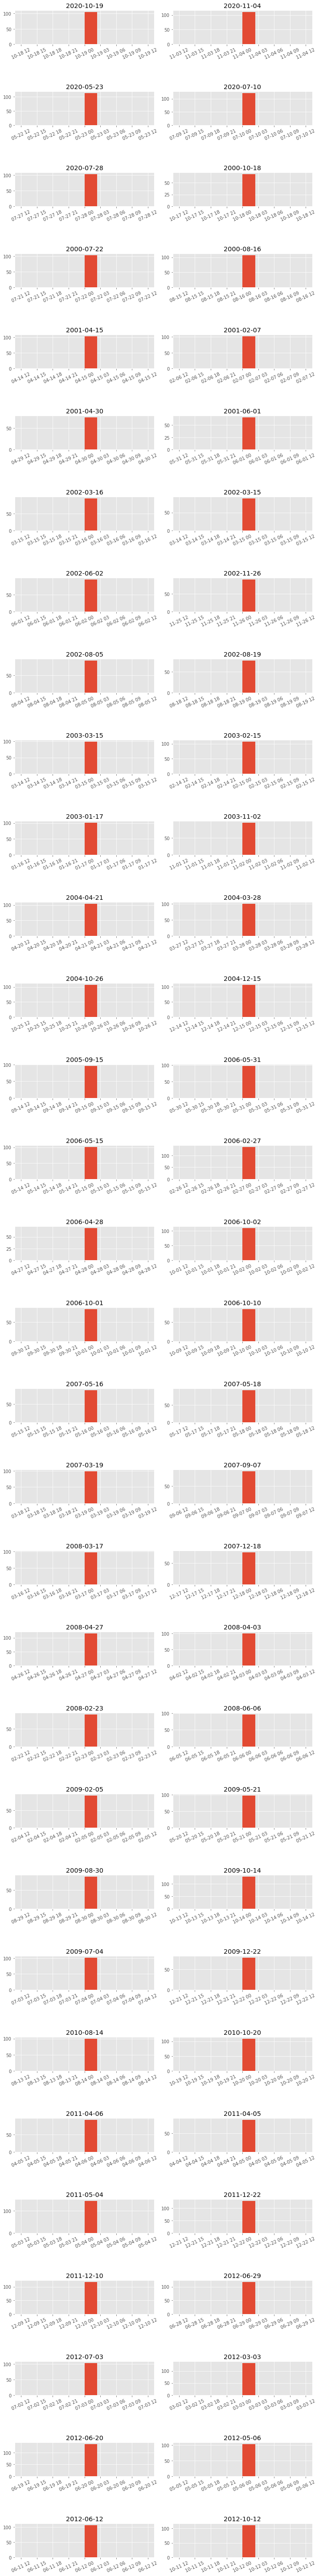

In [507]:
#take a look at the predominant call type from that day
fig, axs = plt.subplots(32,2, figsize = (10,80))
fig.tight_layout()
plt.subplots_adjust(hspace=1.4)
for (i, j) in zip(df['Received DtTm'].apply(lambda x: x.date())[df['Unit sequence in call dispatch'] > 30].unique(), axs.flatten()):
    df['Received DtTm'].apply(lambda x: x.date())[df['Received DtTm'].apply(lambda x: x.date()) == i].hist(xrot = 25, ax = j)
    j.set_title(str(i))


In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389395 entries, 0 to 545476
Data columns (total 14 columns):
Call Number                             389395 non-null int64
Call Type                               389395 non-null object
Call Date                               389395 non-null datetime64[ns]
Original Priority                       387800 non-null object
Priority                                389395 non-null object
Final Priority                          389395 non-null int64
ALS Unit                                389395 non-null bool
Number of Alarms                        389395 non-null int64
Unit Type                               389395 non-null object
Unit sequence in call dispatch          389393 non-null float64
Neighborhooods - Analysis Boundaries    389395 non-null object
call_to_disp                            389395 non-null float64
disp_to_resp                            389395 non-null float64
resp_to_scene                           389395 non-null float64


### Investigate Call Type

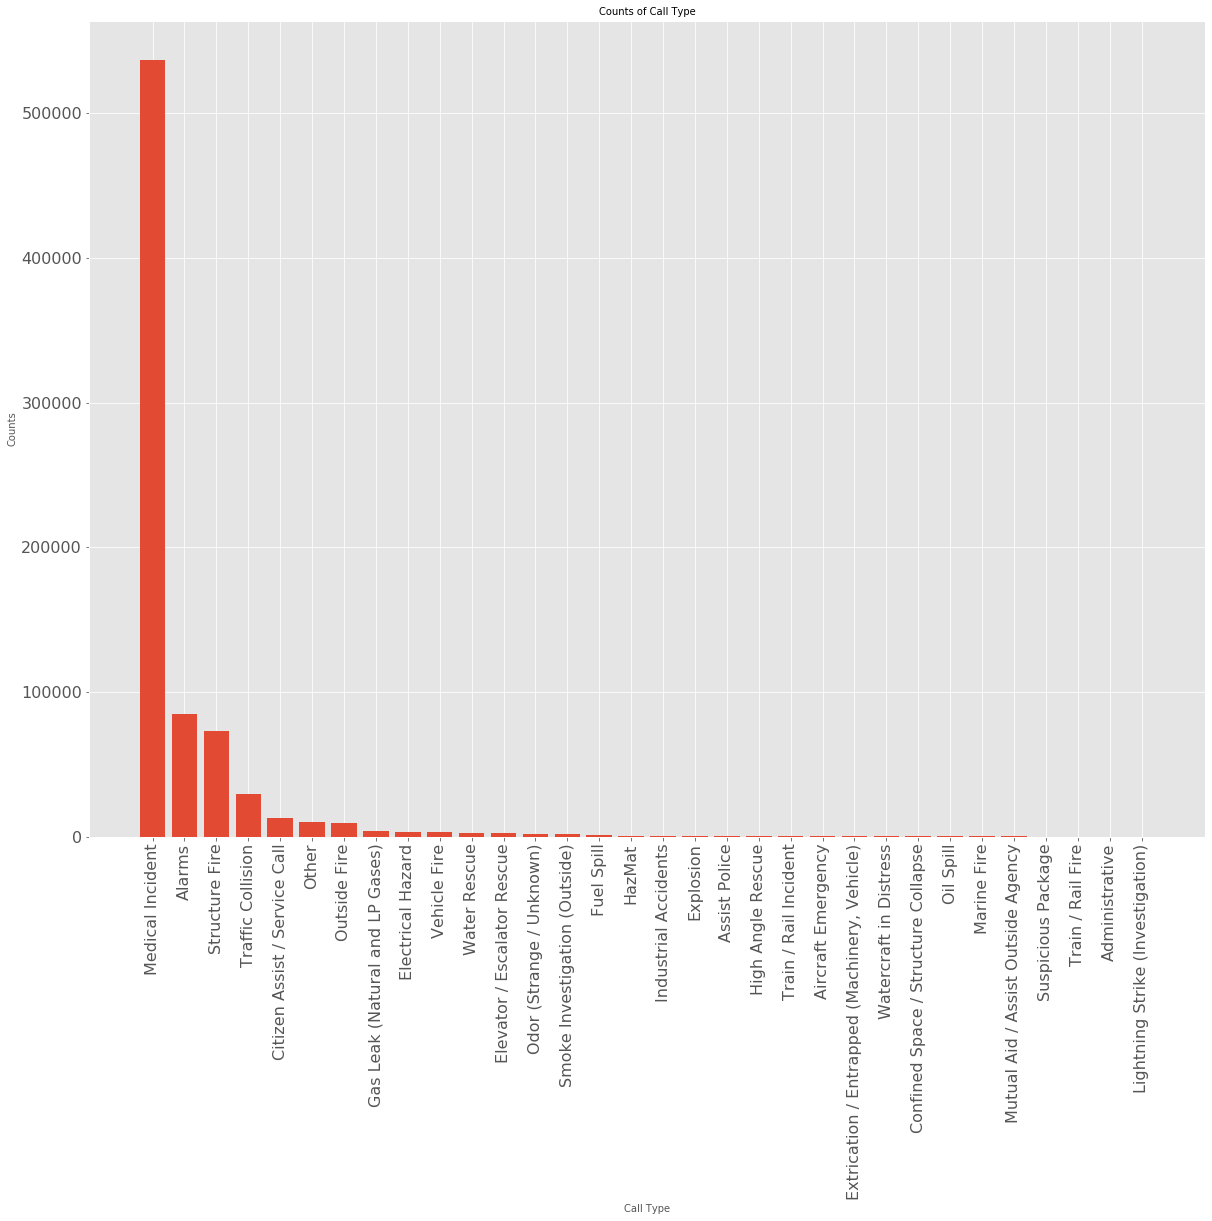

In [508]:
plot_bar_graph(df, 'Call Type', tick_size=16)

In [509]:
df.groupby(by='Call Type').mean()['call_to_disp']

Call Type
Administrative                                  204.285714
Aircraft Emergency                              143.735294
Alarms                                          112.935134
Assist Police                                   212.160920
Citizen Assist / Service Call                   187.635267
Confined Space / Structure Collapse             186.082353
Electrical Hazard                               172.265780
Elevator / Escalator Rescue                     154.280483
Explosion                                       148.097264
Extrication / Entrapped (Machinery, Vehicle)    168.181818
Fuel Spill                                      178.432536
Gas Leak (Natural and LP Gases)                 160.140922
HazMat                                          241.082456
High Angle Rescue                               246.624242
Industrial Accidents                            172.543943
Lightning Strike (Investigation)                271.000000
Marine Fire                                   

Text(0.5, 1.0, 'Call To Dispatch')

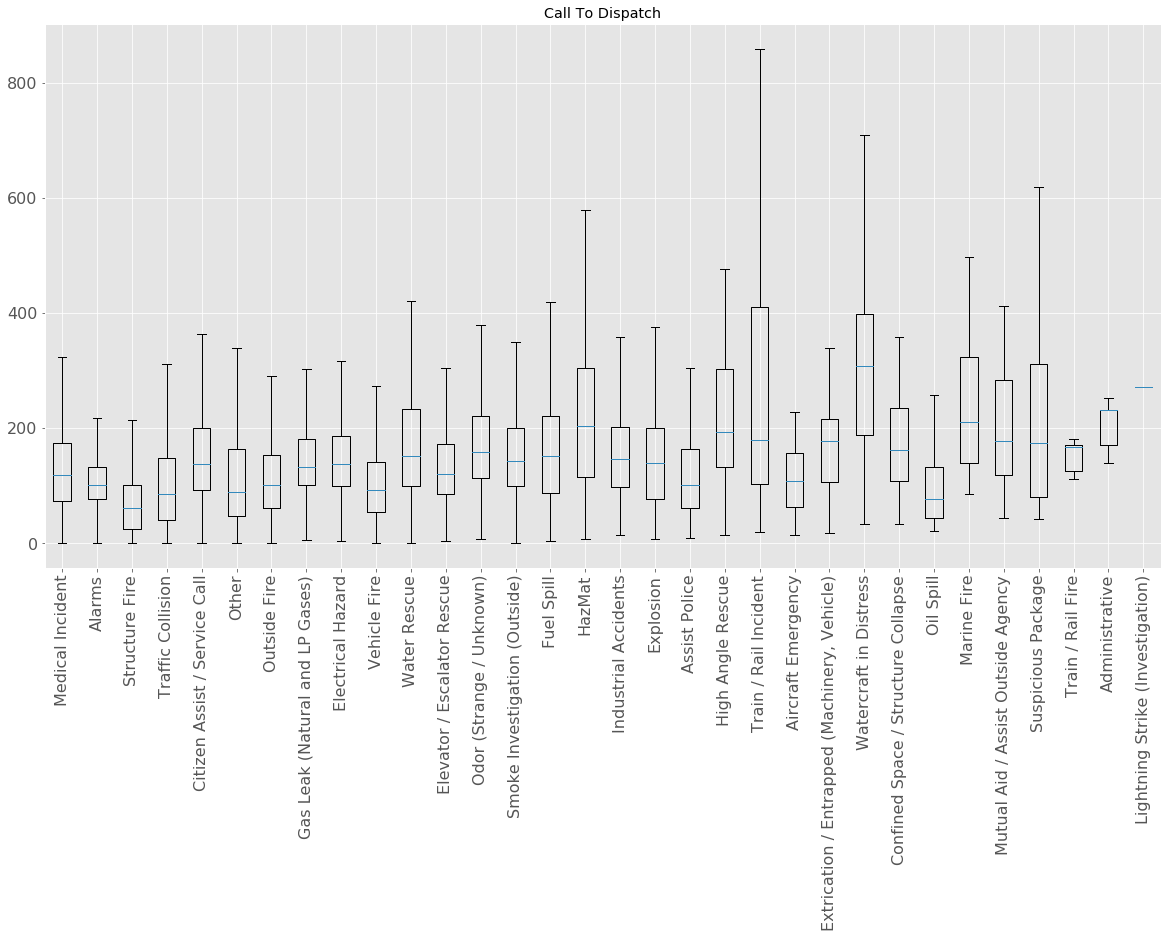

In [510]:
#check if any of the existing Call Types have really distinct distributions of time - matching order doesn't matter
df_searchable = df.set_index('Call Type')['call_to_disp']
groups = df['Call Type'].value_counts().index
all_vals = []

for i in groups:
    all_vals.append(df_searchable[df_searchable.index == i].values)
    
plt.figure(figsize =(20,10))
plt.boxplot(all_vals, sym='', labels=groups)
plt.xticks(rotation='vertical')
plt.tick_params(labelsize=16)
plt.title('Call To Dispatch')



In [511]:
#potentially distinct ones: Watercraft in distress, High Angle Rescue, Train / Rail Incident

Text(0.5, 1.0, 'Dispatch To Response Time')

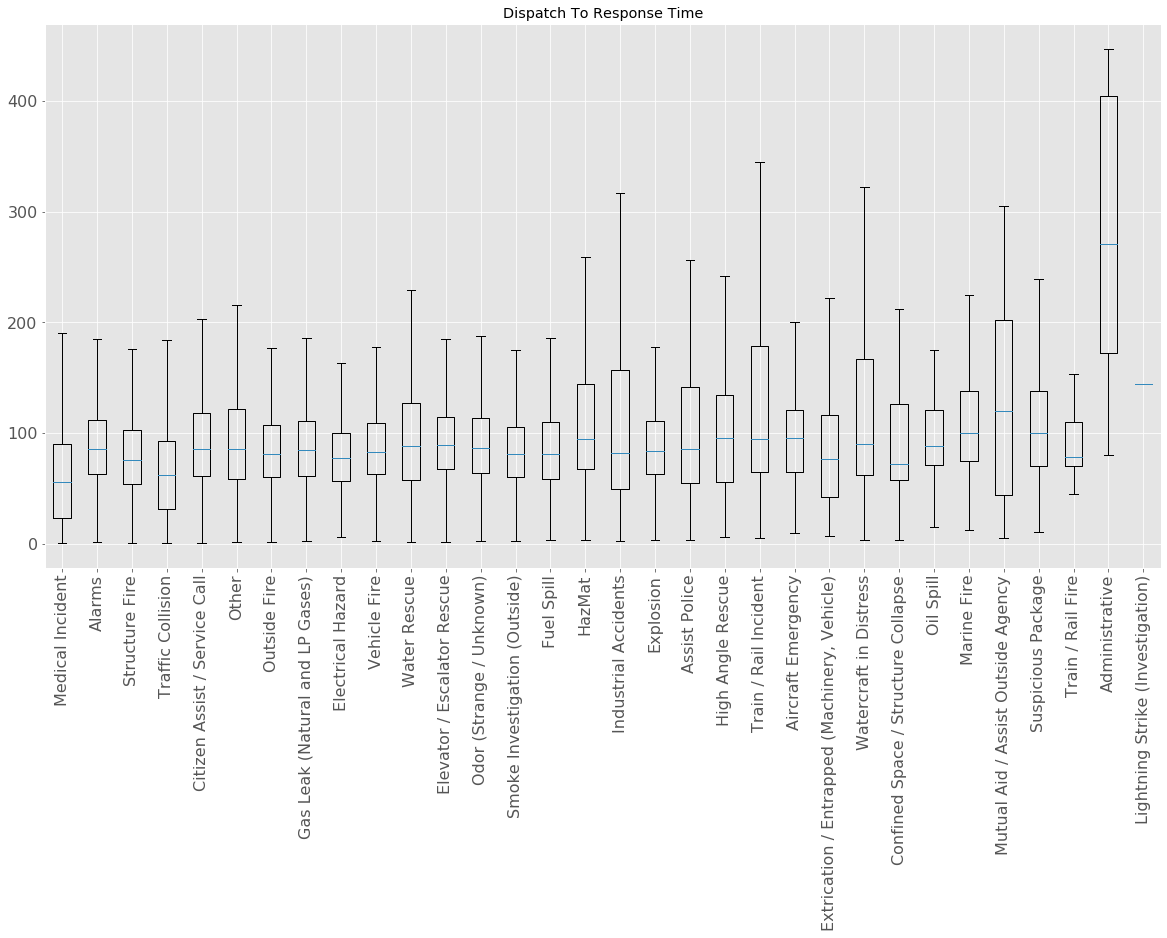

In [512]:
#check if any of the existing Call Types have really distinct distributions of time - matching order doesn't matter
df_searchable = df.set_index('Call Type')['disp_to_resp']
groups = df['Call Type'].value_counts().index
all_vals = []

for i in groups:
    all_vals.append(df_searchable[df_searchable.index == i].values)
    
plt.figure(figsize =(20,10))
plt.boxplot(all_vals, sym='', labels=groups)
plt.xticks(rotation='vertical')
plt.tick_params(labelsize=16)
plt.title('Dispatch To Response Time')



In [513]:
#potentially distinct ones: None

Text(0.5, 1.0, 'Response to On Scene Time')

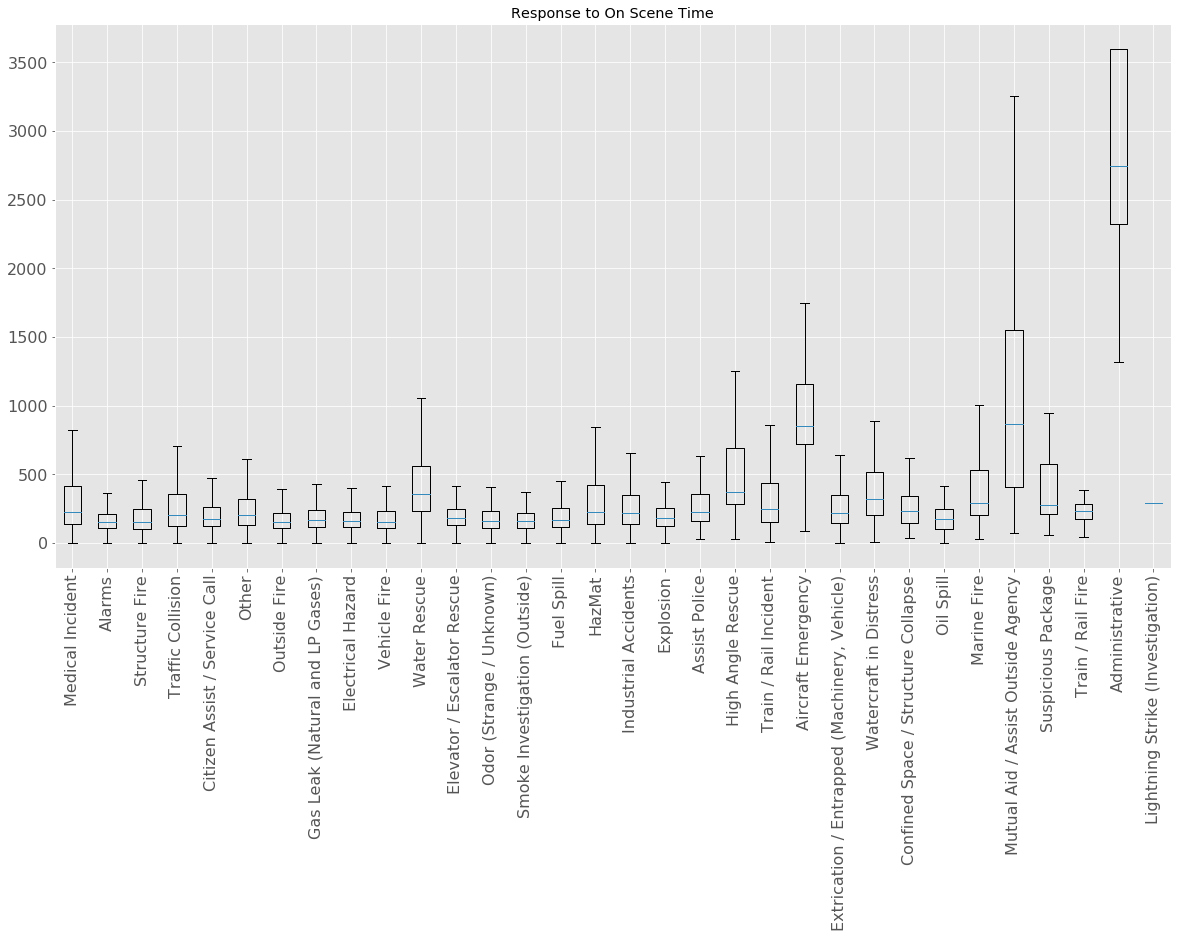

In [514]:
#check if any of the existing Call Types have really distinct distributions of time - matching order doesn't matter
df_searchable = df.set_index('Call Type')['resp_to_scene']
groups = df['Call Type'].value_counts().index
all_vals = []

for i in groups:
    all_vals.append(df_searchable[df_searchable.index == i].values)
    
plt.figure(figsize =(20,10))
plt.boxplot(all_vals, sym='', labels=groups)
plt.xticks(rotation='vertical')
plt.tick_params(labelsize=16)
plt.title('Response to On Scene Time')



In [517]:
#potentially distinct ones: Administrative, Aircraft Emergecy, High Angle Rescue, Water Rescue,
#Mutual Aid / Assist Outside Agency, Train / Rail Fire


In [518]:
#can delete rows with "Administrative", not interested in them
df  = df[df['Call Type'] != 'Administrative']

In [521]:
#don't congregate into other
no_congr = ['Watercraft in Distress','High Angle Rescue','Train / Rail Incident',
           'Aircraft Emergency','Water Rescue','Mutual Aid / Assist Outside Agency','Train / Rail Fire']

In [522]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

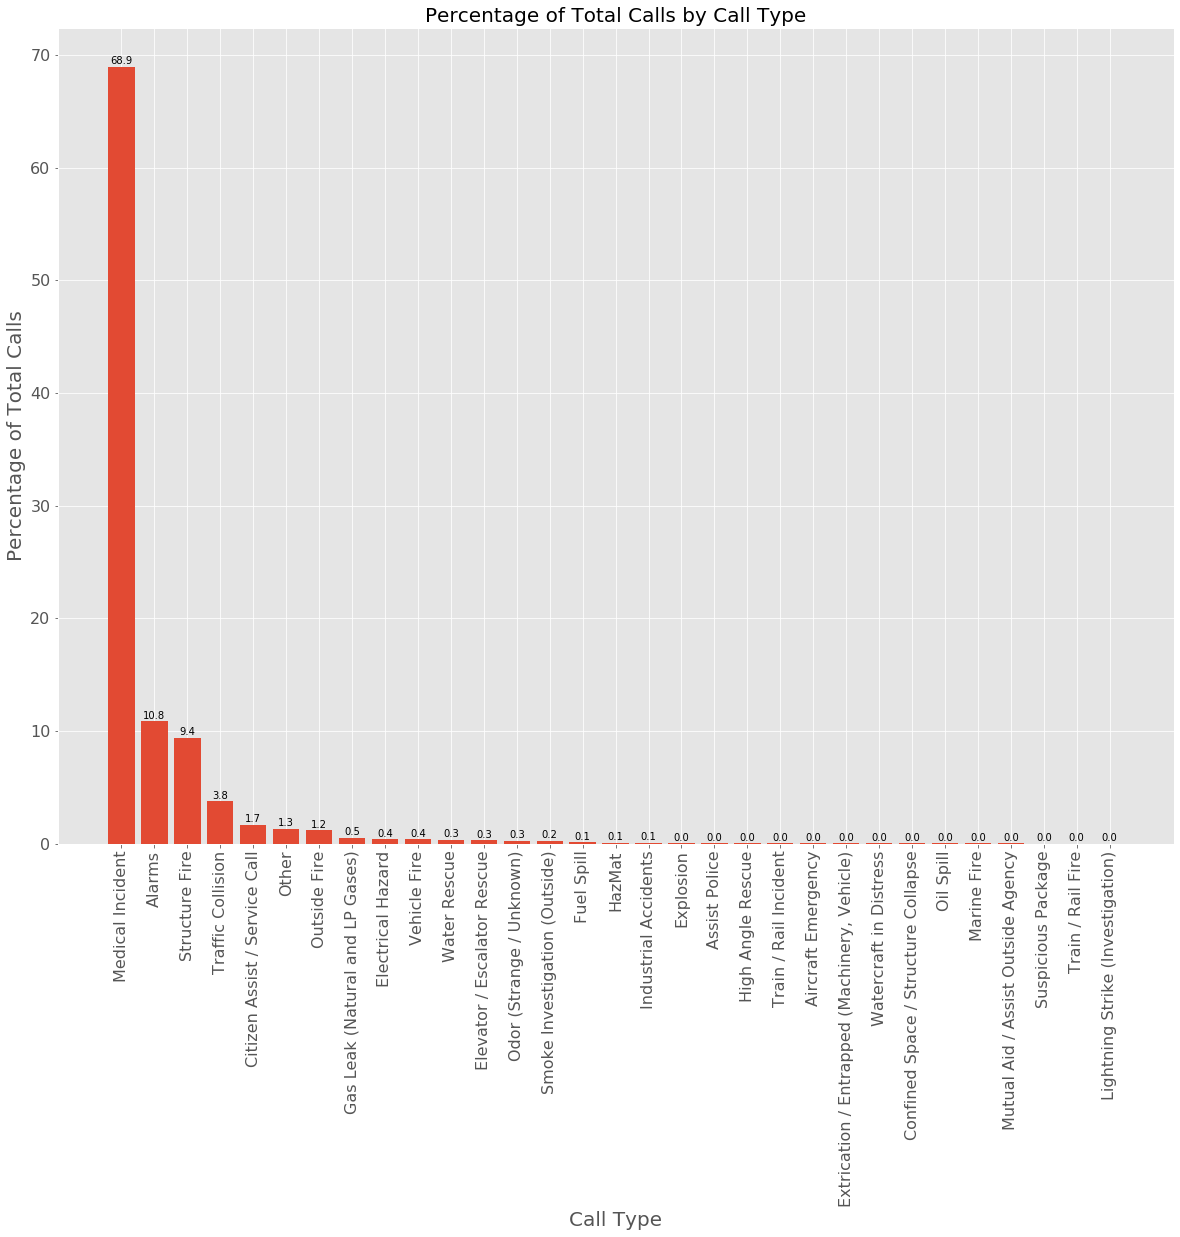

In [523]:
#take a look at what percentage of total cases cutoff to take

#set figure size
plt.figure(figsize =(20,15))  
#set labels with consistent order
labels_ = df['Call Type'].value_counts().index
#set xticks to appropriate location and with appropriate ordered labels
plt.xticks(ticks=range(len(labels_)), labels = labels_, rotation='vertical')
#plot each call type as the percentage of total calls
s = plt.bar(x = df['Call Type'].value_counts().index, height = (df['Call Type'].value_counts().values/len(df))*100)
plt.tick_params(labelsize=16)
plt.ylabel('Percentage of Total Calls', fontdict = {'fontsize' : 20,})
plt.xlabel('Call Type',fontdict = {'fontsize' : 20})
plt.title('Percentage of Total Calls by Call Type',fontdict = {'fontsize' : 20})

#function to show values
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., height+.05,
                f'{height:.1f}',
                ha='center', va='bottom')
autolabel(s)


In [524]:
#lets combine everything that has <= 1% of
keep = list(df['Call Type'].value_counts().index[df['Call Type'].value_counts().values/len(df) > 0.01])

In [525]:
# add on other keep
keep += no_congr
print(keep)

['Medical Incident', 'Alarms', 'Structure Fire', 'Traffic Collision', 'Citizen Assist / Service Call', 'Other', 'Outside Fire', 'Watercraft in Distress', 'High Angle Rescue', 'Train / Rail Incident', 'Aircraft Emergency', 'Water Rescue', 'Mutual Aid / Assist Outside Agency', 'Train / Rail Fire']


In [526]:
#convert anything call type not in list to 'Other'
df['Call Type'] = df['Call Type'].apply(lambda x: x if x in keep else 'Other')

/home/christopher/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Investigate Original Priority

In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778777 entries, 0 to 1090885
Data columns (total 15 columns):
Call Number                             778777 non-null int64
Call Type                               778777 non-null object
Received DtTm                           778777 non-null datetime64[ns]
Original Priority                       775682 non-null object
Priority                                778777 non-null object
Final Priority                          778777 non-null int64
ALS Unit                                778777 non-null bool
Call Type Group                         388841 non-null object
Number of Alarms                        778777 non-null int64
Unit Type                               778777 non-null object
Unit sequence in call dispatch          778771 non-null float64
Neighborhooods - Analysis Boundaries    778777 non-null object
call_to_disp                            778777 non-null float64
disp_to_resp                            778777 non-null float64


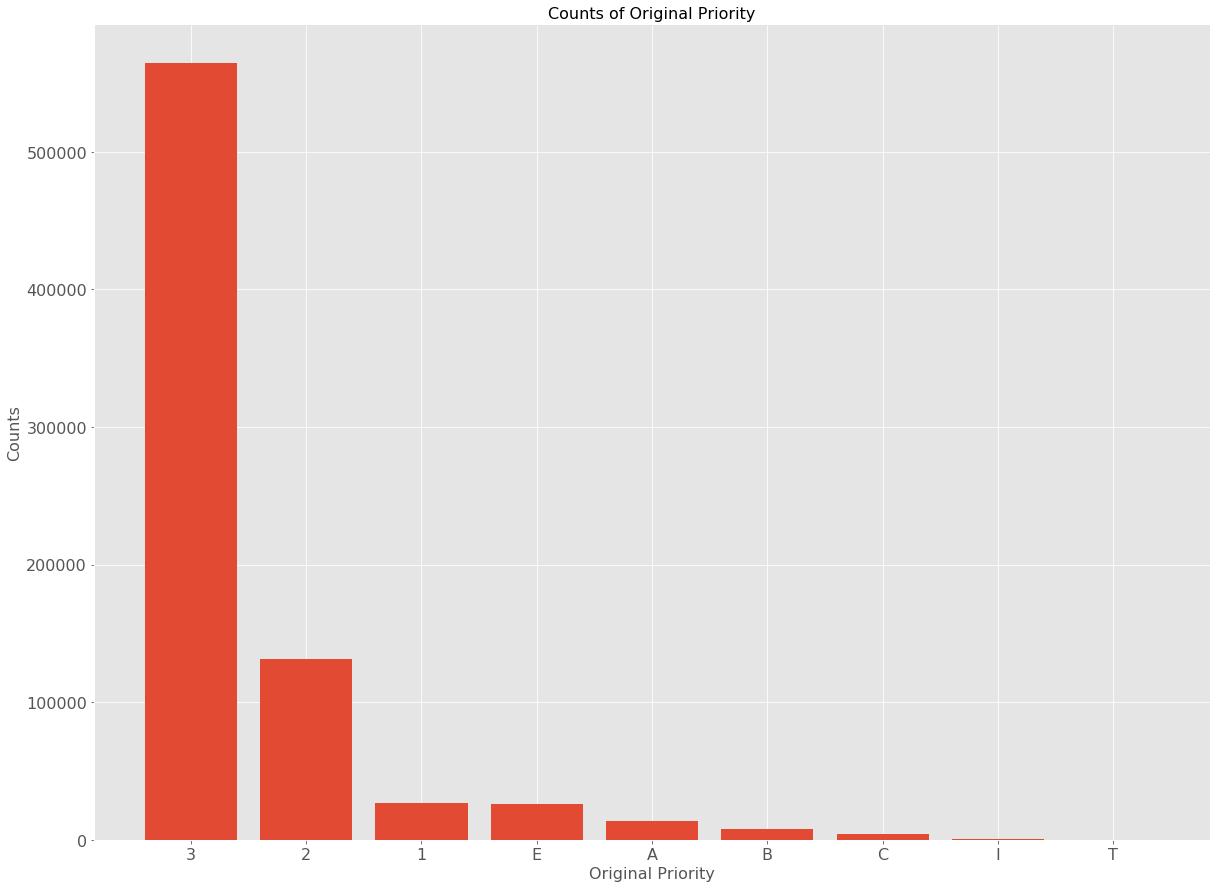

In [528]:
plot_bar_graph(df, 'Original Priority', tick_size = 16, font_size = 16, rot='horizontal')

In [529]:
#can remove samples with I or T, will not bother with them
df = df[~df['Original Priority'].isin(['I','T'])]

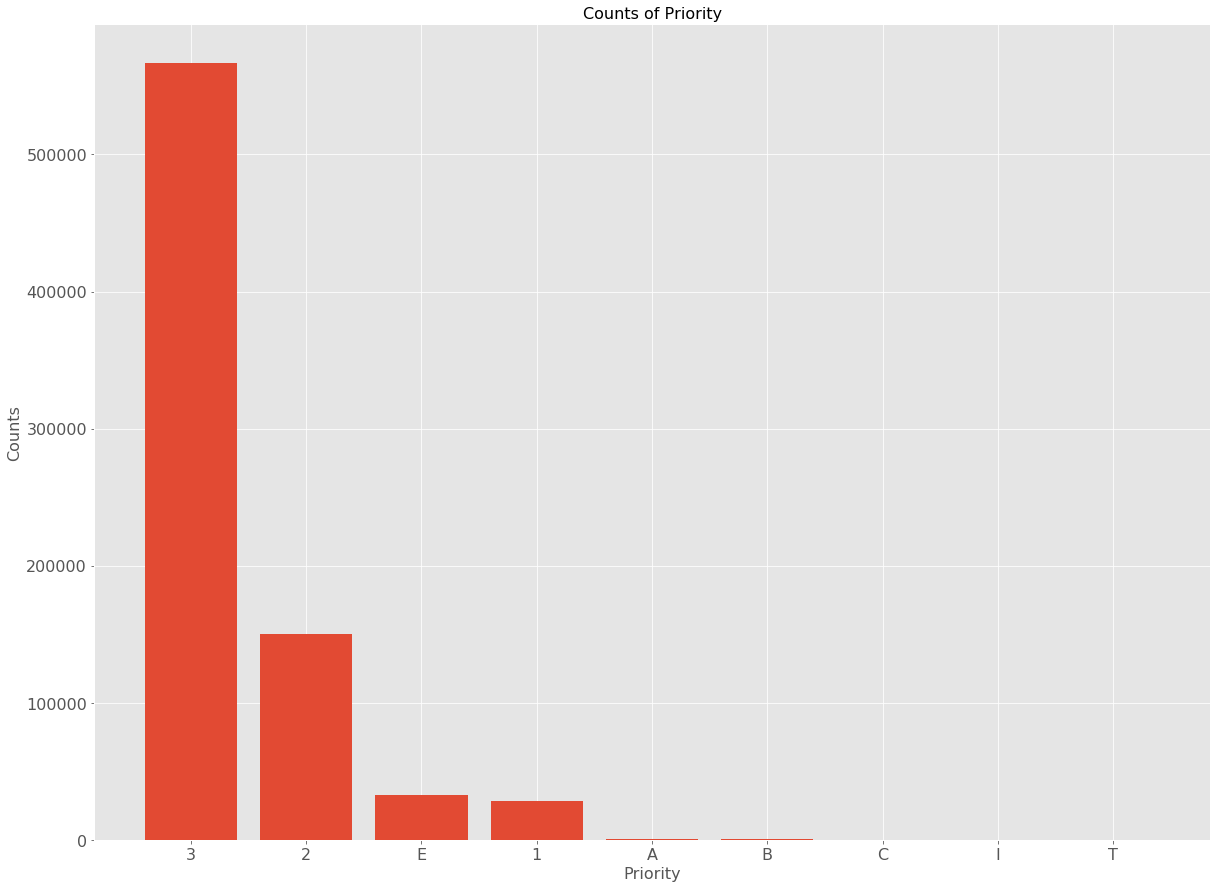

In [530]:
plot_bar_graph(df, 'Priority', tick_size = 16, font_size = 16, rot='horizontal')

In [531]:
#huge correlation: going to remove 'Priority' Entirely
df.drop(labels='Priority', axis=1, inplace=True)

/home/christopher/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


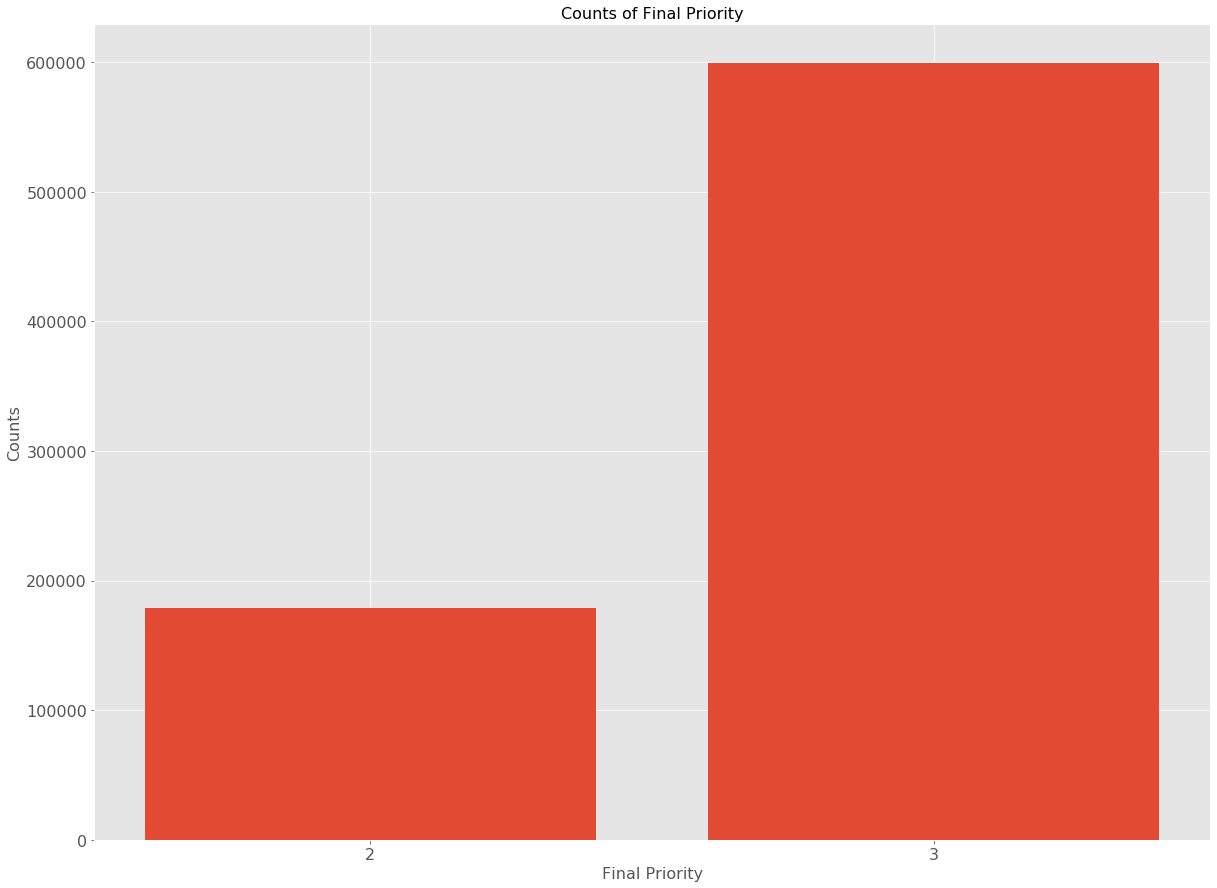

In [532]:
plot_bar_graph(df, 'Final Priority', tick_size = 16, font_size = 16, rot='horizontal')

In [533]:
#don't actually plan on using this so can remove, but good to see final priority distribution
df.drop(labels='Final Priority', axis=1, inplace=True)

In [534]:
df.columns

Index(['Call Number', 'Call Type', 'Received DtTm', 'Original Priority',
       'ALS Unit', 'Call Type Group', 'Number of Alarms', 'Unit Type',
       'Unit sequence in call dispatch',
       'Neighborhooods - Analysis Boundaries', 'call_to_disp', 'disp_to_resp',
       'resp_to_scene'],
      dtype='object')

### Investigate ALS Unit

In [535]:
df['ALS Unit'].value_counts()

True     509432
False    268740
Name: ALS Unit, dtype: int64

In [536]:
sum(df['ALS Unit'].isnull())

0

In [537]:
#good to use - will convert later

### Investigate Number of Alarms

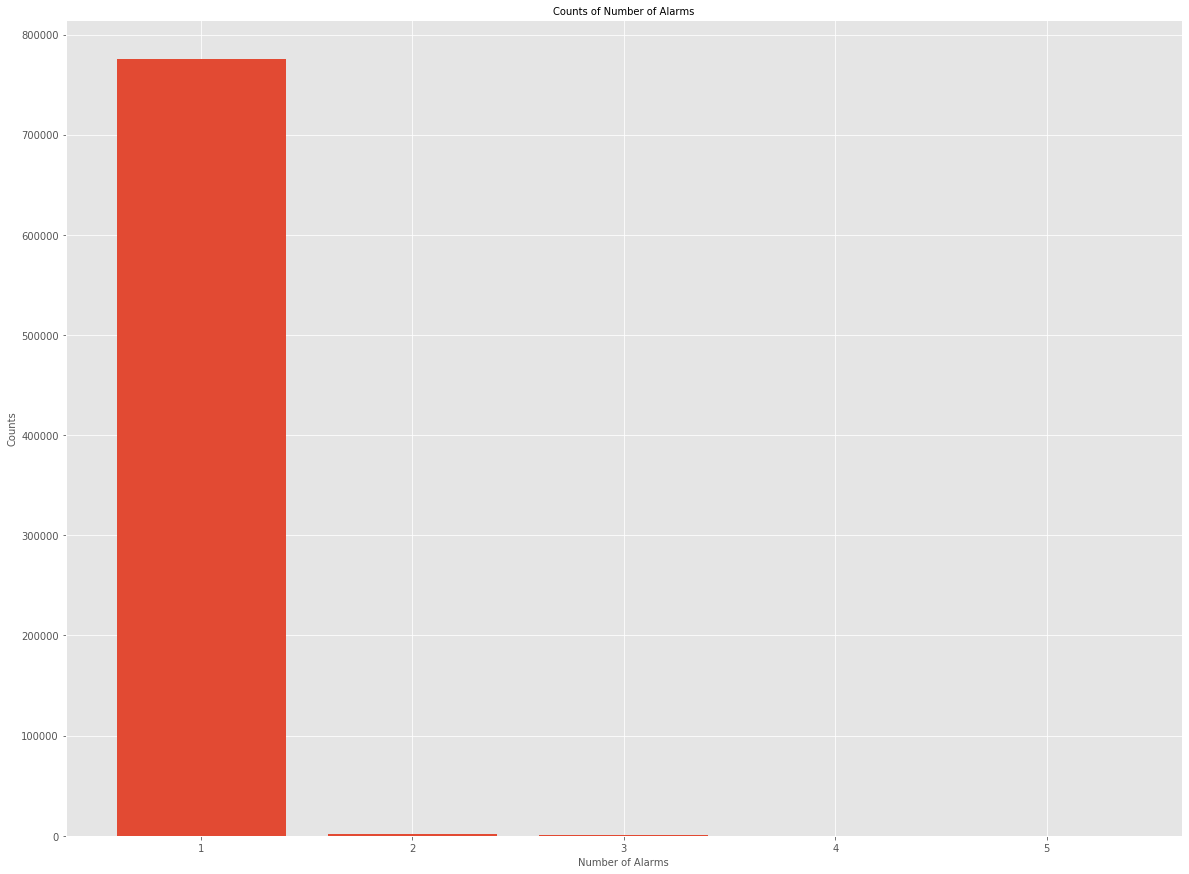

In [538]:
plot_bar_graph(df,'Number of Alarms')

In [539]:
#not meaningful, drop columns
df.drop(labels='Number of Alarms',axis=1, inplace = True)

In [540]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778172 entries, 0 to 1090885
Data columns (total 12 columns):
Call Number                             778172 non-null int64
Call Type                               778172 non-null object
Received DtTm                           778172 non-null datetime64[ns]
Original Priority                       775077 non-null object
ALS Unit                                778172 non-null bool
Call Type Group                         388241 non-null object
Unit Type                               778172 non-null object
Unit sequence in call dispatch          778166 non-null float64
Neighborhooods - Analysis Boundaries    778172 non-null object
call_to_disp                            778172 non-null float64
disp_to_resp                            778172 non-null float64
resp_to_scene                           778172 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 92.0+ MB


### Investigate Unit Type

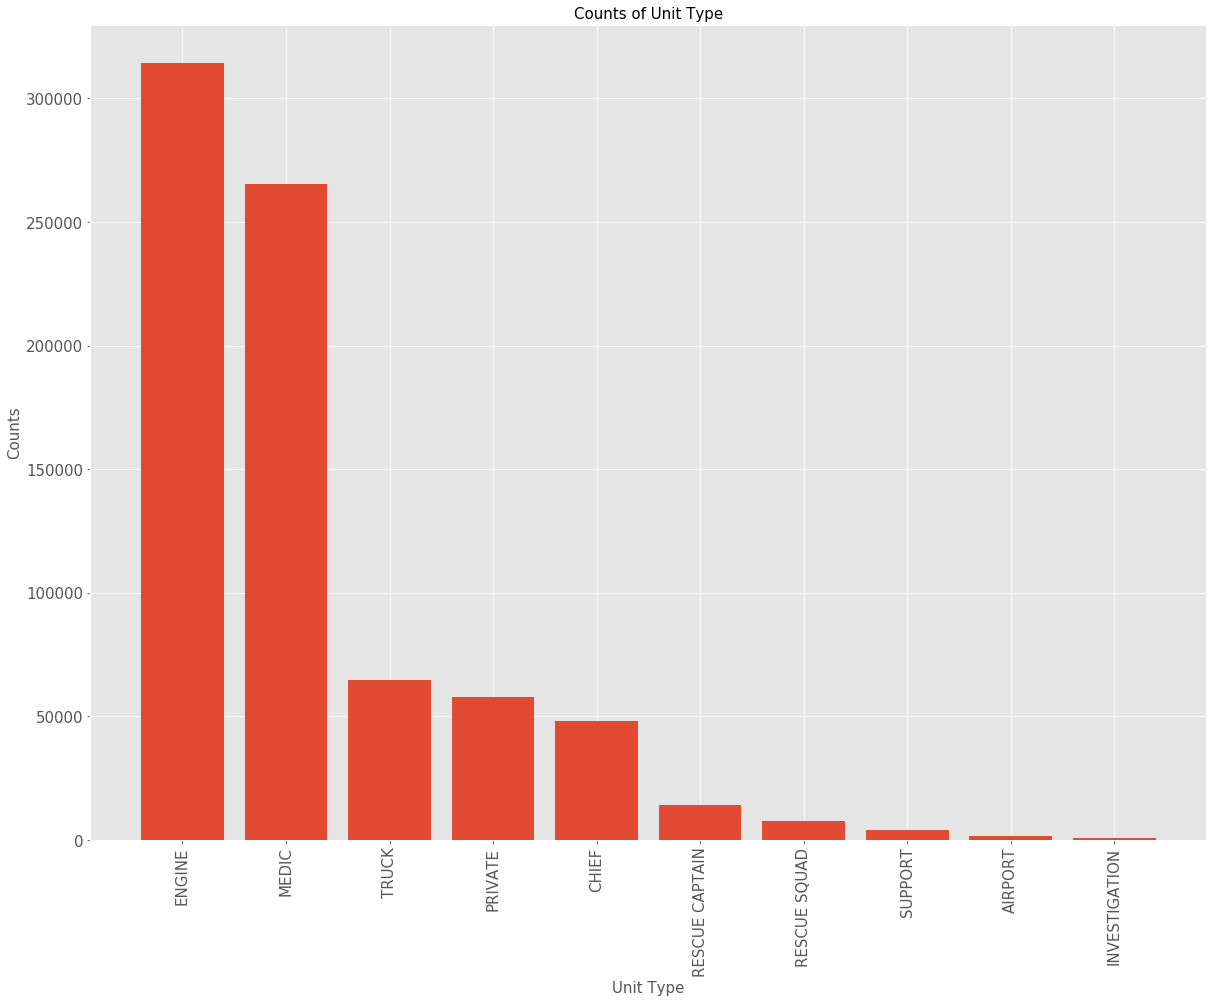

In [541]:
plot_bar_graph(df, 'Unit Type',font_size=15, tick_size=15 )

In [542]:
#will keep these

### Investigate Neighborhooods - Analysis Boundaries

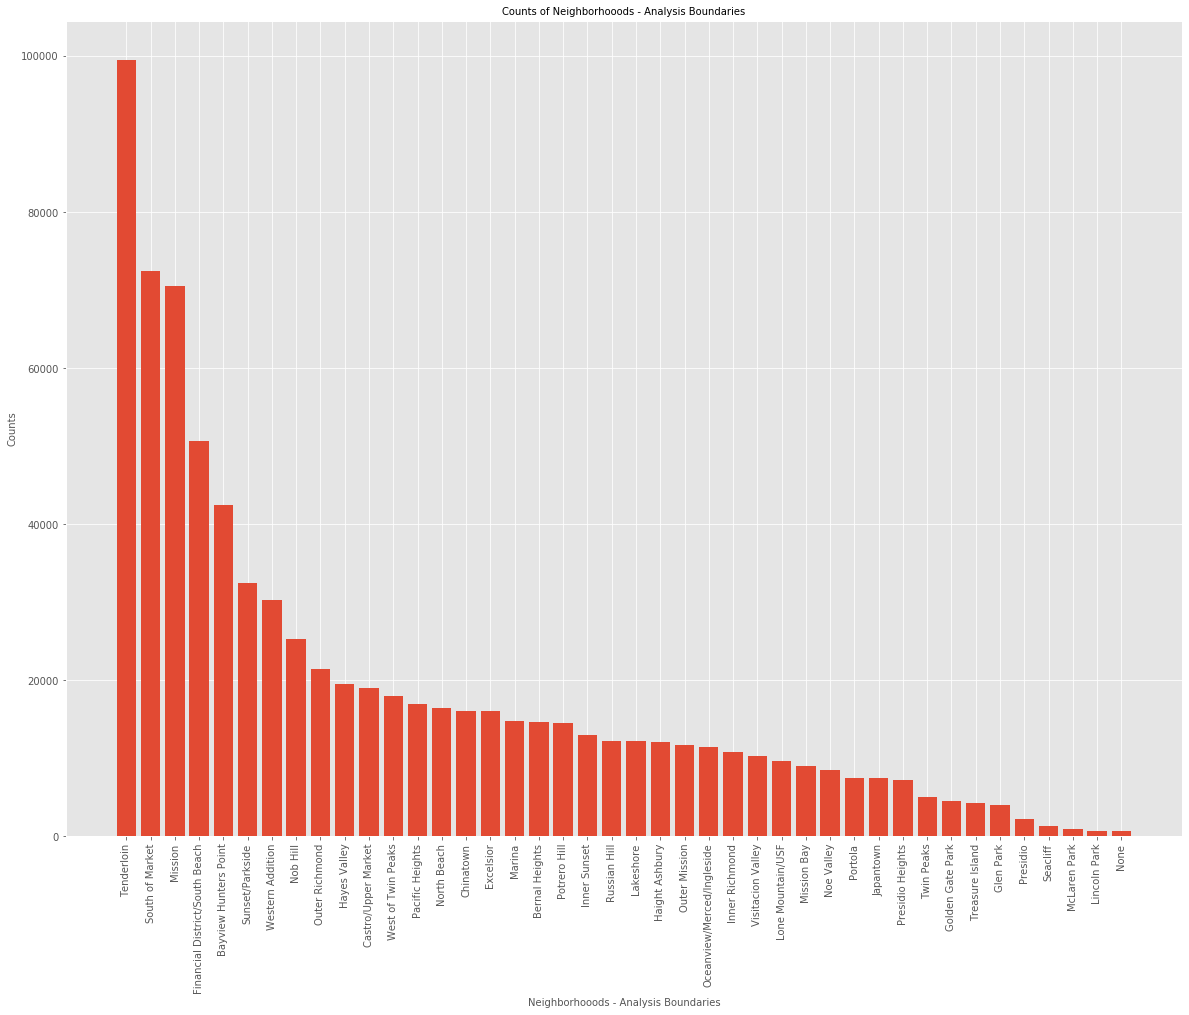

In [543]:
plot_bar_graph(df,'Neighborhooods - Analysis Boundaries')

In [544]:
#can keep all of these

### Investigate Call Type Group

In [548]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 778172 entries, 0 to 1090885
Data columns (total 12 columns):
Call Number                             778172 non-null int64
Call Type                               778172 non-null object
Received DtTm                           778172 non-null datetime64[ns]
Original Priority                       775077 non-null object
ALS Unit                                778172 non-null bool
Call Type Group                         388241 non-null object
Unit Type                               778172 non-null object
Unit sequence in call dispatch          778166 non-null float64
Neighborhooods - Analysis Boundaries    778172 non-null object
call_to_disp                            778172 non-null float64
disp_to_resp                            778172 non-null float64
resp_to_scene                           778172 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 92.0+ MB


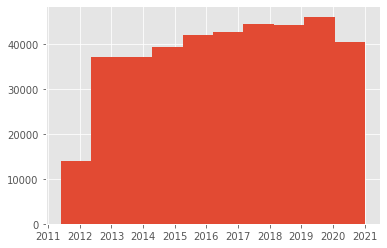

In [550]:
df['Received DtTm'][~df['Call Type Group'].isnull()].hist()

In [551]:
#still too sparse to use
df.drop(labels = 'Call Type Group', axis=1, inplace = True)

## Delete any final rows with null

In [552]:
#code to check what proportion of rows have at least 1 null
(len(df)-(sum((~df.isna()).all(axis=1))))/len(df)

0.003977269806675131

In [553]:
#code to include only rows with no null values
df = df[(~df.isnull()).all(axis=1)]
len(df)

775077

### Do some feature engineering on date

In [556]:
df['Received DtTm'][0].dayofweek

2

In [414]:
#get year from date
#There is a steady trend in the increase in calls, so I will leave year as numeric column
df['Call Year'] = df['Received DtTm'].apply(lambda x: x.year)

In [419]:
#get month from date
#There is seasonality in months, so will need to dummify
df['Call Month'] = df['Received DtTm'].apply(lambda x: x.month)

In [435]:
#get dayofweek from date
#There is seasonality in months, so will need to dummify
df['Call DoW'] = df['Received DtTm'].apply(lambda x: x.dayofweek)

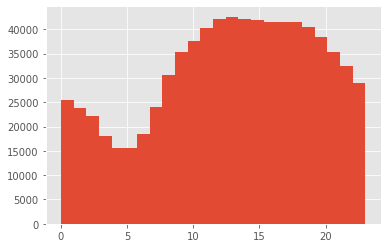

In [571]:
df['Received DtTm'].apply(lambda x: x.hour).hist(bins=24)

In [573]:
#want to capture 0-2,3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23
int(3/3)

1

In [575]:
#get time of day in 3 hour increments
df['Call ToD'] = df['Received DtTm'].apply(lambda x: int(x.hour/3))

In [577]:
df['Call ToD'].value_counts()

4    126651
5    124817
6    120260
3    113136
7     96693
2     72874
0     71461
1     49185
Name: Call ToD, dtype: int64

In [581]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775077 entries, 0 to 1090885
Data columns (total 11 columns):
Call Type                               775077 non-null object
Received DtTm                           775077 non-null datetime64[ns]
Original Priority                       775077 non-null object
ALS Unit                                775077 non-null bool
Unit Type                               775077 non-null object
Unit sequence in call dispatch          775077 non-null float64
Neighborhooods - Analysis Boundaries    775077 non-null object
call_to_disp                            775077 non-null float64
disp_to_resp                            775077 non-null float64
resp_to_scene                           775077 non-null float64
Call ToD                                775077 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 85.8+ MB


In [585]:
#can get rid of Call Number - can later use it for some feature engineering to see number of responses on a given call
df.drop(labels='Call Number', axis=1, inplace = True)

KeyError: "['Call Number'] not found in axis"

In [ ]:
#columns to keep
df.

## For random forest, convert categorical data to numeric

In [584]:
#converting Call Type
df['Call Type'].unique()

array(['Alarms', 'Medical Incident', 'Outside Fire', 'Traffic Collision',
       'Structure Fire', 'Other', 'Citizen Assist / Service Call',
       'Water Rescue', 'Mutual Aid / Assist Outside Agency',
       'Watercraft in Distress', 'Train / Rail Fire', 'High Angle Rescue',
       'Train / Rail Incident', 'Aircraft Emergency'], dtype=object)

### Removing values where neighborhoods are not listed??

## Ideas

In [ ]:
#find number of calls within +/- 10 min range from call to estimate the surge at that time to use as feature
